In [1]:
import pandas as pd
import numpy as np
import sklearn
from math import pi
from tqdm.auto import tqdm
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
sklearn.__version__

'1.6.1'

# Load Data

In [3]:
parquet_file = pq.ParquetFile('/content/drive/My Drive/time_series/competition_data/wip/sales_train_evaluation_processed3.parquet')

In [4]:
def reduce_mem_usage(df):
    """
    Reduces memory usage of a pandas DataFrame by optimizing data types.
    Handles numeric, categorical, timestamp, and string data intelligently.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to optimize

    Returns:
    --------
    pandas.DataFrame
        The memory-optimized DataFrame
    """
    import numpy as np
    import pandas as pd
    import re

    # start_mem = df.memory_usage().sum() / 1024**2
    # print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        # Handle timestamp data that's already recognized
        if pd.api.types.is_datetime64_any_dtype(col_type):
            # Timestamps are already efficiently stored
            continue

        # Handle numeric data (int and float)
        elif pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # Handle integer data
            if pd.api.types.is_integer_dtype(col_type):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Handle float data
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        # Handle boolean data
        elif pd.api.types.is_bool_dtype(col_type):
            df[col] = df[col].astype(bool)

        # Handle string and object data
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_string_dtype(col_type):
            # Skip timestamp detection for columns where we already know they're not timestamps
            if df[col].dtype == 'object' and len(df[col].dropna()) > 0:
                # Get the first non-null value to examine
                first_val = df[col].dropna().iloc[0]

                # Skip datetime conversion if it's not a string or if it's numeric-like
                if not isinstance(first_val, str) or first_val.isdigit():
                    pass
                # Skip datetime conversion for very short strings that can't be dates
                elif isinstance(first_val, str) and len(first_val) < 6:
                    pass
                else:
                    # Only attempt conversion if it looks like a date
                    # Common date patterns as regex
                    date_patterns = [
                        r'\d{4}[-/]\d{1,2}[-/]\d{1,2}',  # YYYY-MM-DD or YYYY/MM/DD
                        r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}',  # DD-MM-YYYY or MM-DD-YYYY
                        r'\d{1,2}\s+[A-Za-z]{3,9}\s+\d{2,4}',  # DD Month YYYY
                        r'[A-Za-z]{3,9}\s+\d{1,2},?\s+\d{2,4}'  # Month DD, YYYY
                    ]

                    # Check if first value matches any date pattern
                    is_date_like = False
                    for pattern in date_patterns:
                        if re.search(pattern, str(first_val)):
                            is_date_like = True
                            break

                    if is_date_like:
                        try:
                            # Try common explicit formats instead of using automatic detection
                            formats_to_try = [
                                '%Y-%m-%d',
                                '%Y/%m/%d',
                                '%d-%m-%Y',
                                '%d/%m/%Y',
                                '%Y-%m-%d %H:%M:%S',
                                '%Y/%m/%d %H:%M:%S',
                                '%d-%m-%Y %H:%M:%S',
                                '%d/%m/%Y %H:%M:%S',
                                '%b %d %Y',
                                '%B %d %Y',
                                '%d %b %Y',
                                '%d %B %Y'
                            ]

                            converted = False
                            for fmt in formats_to_try:
                                try:
                                    # Try to convert using explicit format
                                    temp_series = pd.to_datetime(df[col].head(10), format=fmt, errors='raise')
                                    # If successful, apply to the whole column
                                    df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
                                    converted = True
                                    break
                                except ValueError:
                                    continue

                            # Last resort: if none of the formats work but it still looks like dates,
                            # skip datetime conversion to avoid the warning
                            if not converted:
                                # Instead of using automatic detection, leave as is
                                pass
                        except:
                            pass

            # If it's not a timestamp, check for categorical potential
            if not pd.api.types.is_datetime64_any_dtype(df[col].dtype):
                n_unique = df[col].nunique()
                n_total = len(df)

                # Convert to category only if it has a reasonable number of unique values
                if n_unique / n_total < 0.5:  # Less than 50% unique values
                    df[col] = df[col].astype('category')

        # Handle categorical data
        elif pd.api.types.is_categorical_dtype(col_type):
            pass  # Already optimized

    # end_mem = df.memory_usage().sum() / 1024**2
    # print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    # print(f'Decreased by {(start_mem - end_mem) / start_mem * 100:.1f}%')

    return df

In [5]:
data_dfs = []
for batch in tqdm(parquet_file.iter_batches()):
    batch_df = batch.to_pandas()
    batch_df = reduce_mem_usage(batch_df)
    data_dfs.append(batch_df)

0it [00:00, ?it/s]

In [6]:
data = pd.concat(data_dfs)

In [12]:
data.shape

(59303050, 31)

In [19]:
data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,index_day,sales,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_sin,week_cos,sell_price,week_to_week_ratio,ratio_to_4wk_mean
0,HOUSEHOLD_1_445_CA_1_evaluation,HOUSEHOLD_1_445,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,0,0,0,0.120117,0.992676,NaN,1.0,1.0
1,HOUSEHOLD_1_445_CA_1_evaluation,HOUSEHOLD_1_445,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_2,0,2011-01-30,11101,...,NaN,NaN,0,0,0,0.120117,0.992676,NaN,1.0,1.0
2,HOUSEHOLD_1_445_CA_1_evaluation,HOUSEHOLD_1_445,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_3,0,2011-01-31,11101,...,NaN,NaN,0,0,0,0.120117,0.992676,NaN,1.0,1.0
3,HOUSEHOLD_1_445_CA_1_evaluation,HOUSEHOLD_1_445,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_4,0,2011-02-01,11101,...,NaN,NaN,1,1,0,0.120117,0.992676,NaN,1.0,1.0
4,HOUSEHOLD_1_445_CA_1_evaluation,HOUSEHOLD_1_445,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_5,0,2011-02-02,11101,...,NaN,NaN,1,0,1,0.120117,0.992676,NaN,1.0,1.0


In [20]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'index_day', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'week_sin', 'week_cos', 'sell_price',
       'week_to_week_ratio', 'ratio_to_4wk_mean'],
      dtype='object')

# Analyze

## Seasonality

In [21]:
sales_by_state_weekday = data.groupby(["state_id", "wday"])["sales"].mean()

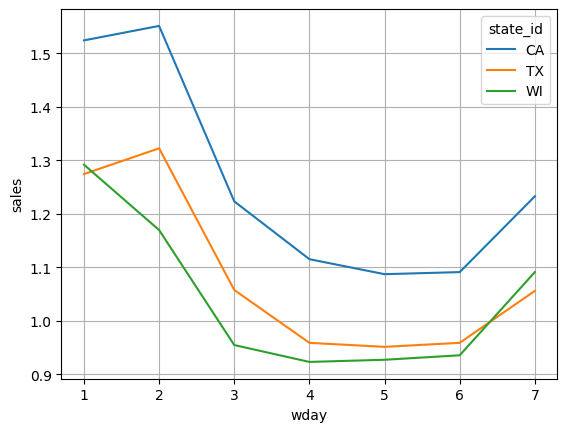

In [26]:
sns.lineplot(data = sales_by_state_weekday.reset_index(), hue="state_id", x="wday", y="sales")
plt.grid()

In [30]:
del sales_by_state_weekday

In [27]:
sales_by_state_month = data.groupby(["state_id", "month"])["sales"].mean()

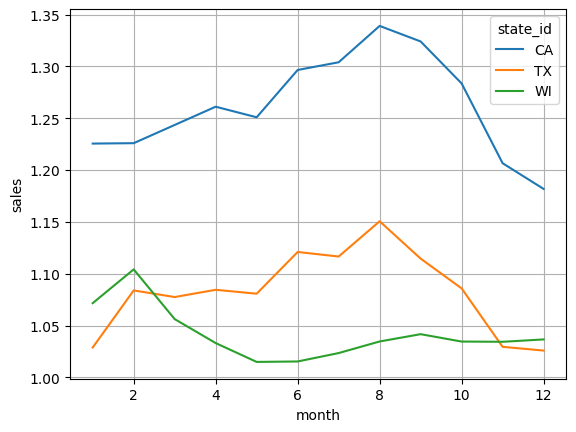

In [29]:
sns.lineplot(data = sales_by_state_month.reset_index(), hue="state_id", x="month", y="sales")
plt.grid()

In [31]:
del sales_by_state_month

In [38]:
samples_data = data.sample(frac=0.05)

# Event Effects

In [13]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'index_day', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'event_name', 'event_type', 'snap_CA', 'snap_TX', 'snap_WI', 'week_sin',
       'week_cos', 'days_until_Religious', 'days_until_National',
       'days_until_Cultural', 'days_until_Sporting',
       'next_Religious_event_name', 'next_National_event_name',
       'next_Cultural_event_name', 'next_Sporting_event_name', 'sell_price',
       'week_to_week_ratio', 'ratio_to_4wk_mean'],
      dtype='object')

In [15]:
data.dtypes

,0
id,object
item_id,object
dept_id,object
cat_id,object
store_id,object
state_id,object
index_day,category
sales,int16
date,datetime64[ns]
wm_yr_wk,int16


In [7]:
data["sales"] = data["sales"].astype(float)

In [9]:
# Check data types
print(data["state_id"].dtype)
print(data["days_until_Religious"].dtype)

object
float16


### Event effect by states

In [11]:
data["days_until_Religious"] = data["days_until_Religious"].astype('float64')

In [13]:
days_until_groupby = data.groupby(["state_id", "days_until_Religious"])["sales"].mean().reset_index()
days_until_groupby.head()

,state_id,days_until_Religious,sales
0,CA,0.0,1.232195
1,CA,1.0,1.200621
2,CA,2.0,1.215523
3,CA,3.0,1.249108
4,CA,4.0,1.309875


<Axes: xlabel='days_until_Religious', ylabel='sales'>

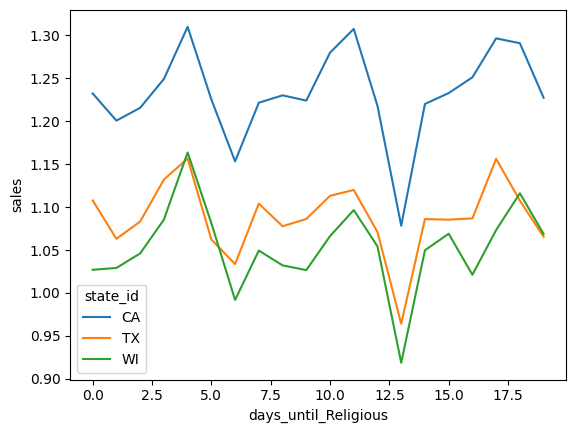

In [14]:
sns.lineplot(days_until_groupby[days_until_groupby["days_until_Religious"]<20],
             x="days_until_Religious", y="sales", hue="state_id")

In [17]:
data["days_until_National"] = data["days_until_National"].astype('float64')

In [18]:
days_until_groupby = data.groupby(["state_id", "days_until_National"])["sales"].mean().reset_index()
days_until_groupby.head()

,state_id,days_until_National,sales
0,CA,0.0,1.074753
1,CA,1.0,1.345456
2,CA,2.0,1.366443
3,CA,3.0,1.232997
4,CA,4.0,1.172887


<Axes: xlabel='days_until_National', ylabel='sales'>

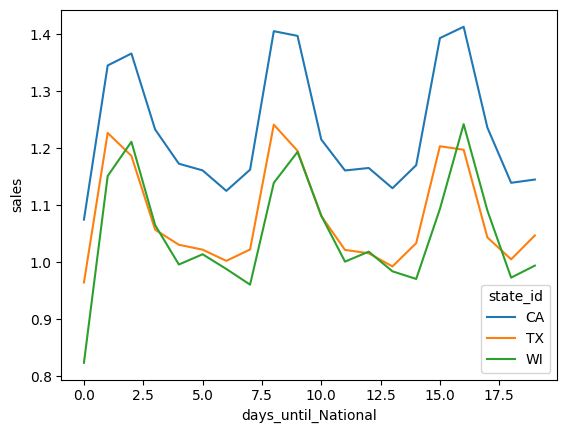

In [21]:
sns.lineplot(days_until_groupby[days_until_groupby["days_until_National"]<20],
             x="days_until_National", y="sales", hue="state_id")

In [23]:
data["days_until_Cultural"] = data["days_until_Cultural"].astype('float64')

In [26]:
days_until_groupby = data.groupby(["state_id", "days_until_Cultural"])["sales"].mean().reset_index()


<Axes: xlabel='days_until_Cultural', ylabel='sales'>

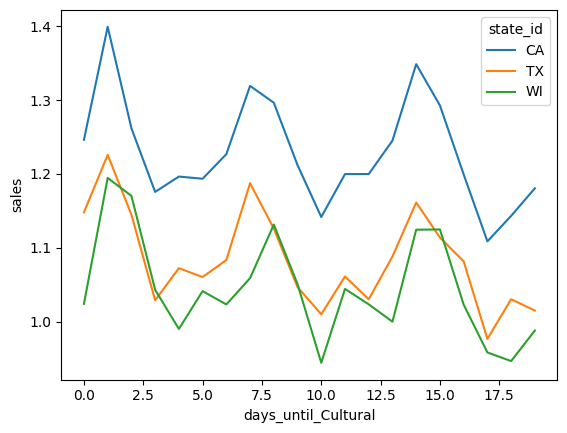

In [27]:
sns.lineplot(days_until_groupby[days_until_groupby["days_until_Cultural"]<20],
             x="days_until_Cultural", y="sales", hue="state_id")

In [28]:
data["days_until_Sporting"] = data["days_until_Sporting"].astype('float64')

In [29]:
days_until_groupby = data.groupby(["state_id", "days_until_Sporting"])["sales"].mean().reset_index()

<Axes: xlabel='days_until_Sporting', ylabel='sales'>

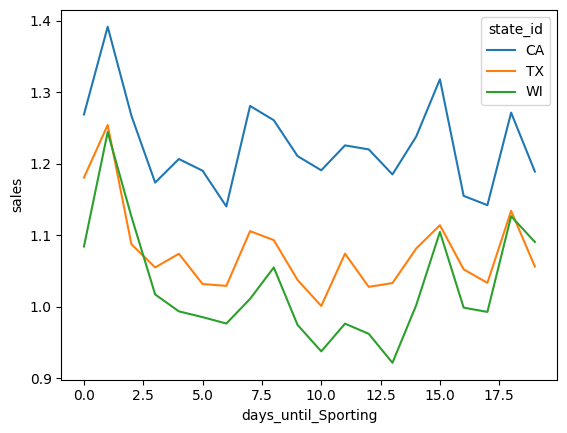

In [30]:
sns.lineplot(days_until_groupby[days_until_groupby["days_until_Sporting"]<20],
             x="days_until_Sporting", y="sales", hue="state_id")

Event effect by dept_id

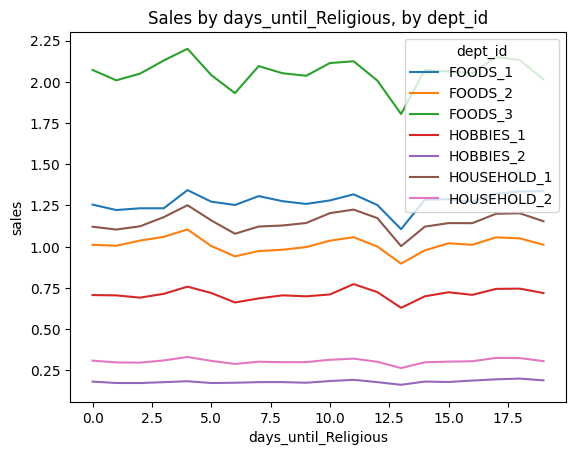

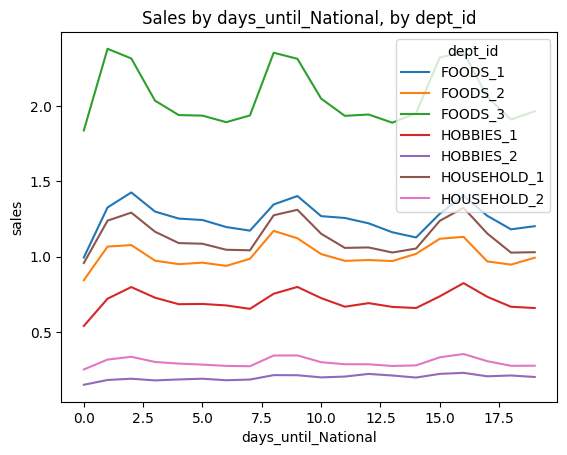

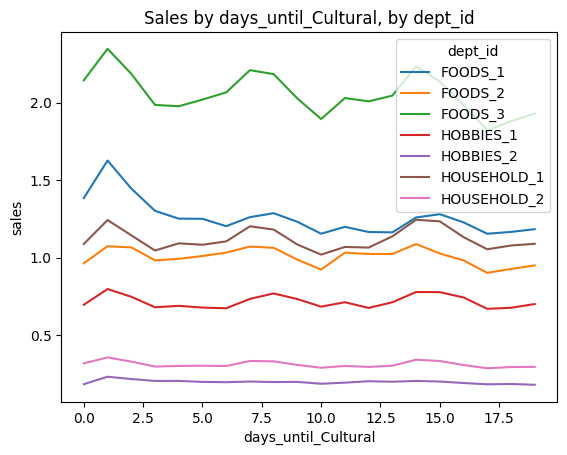

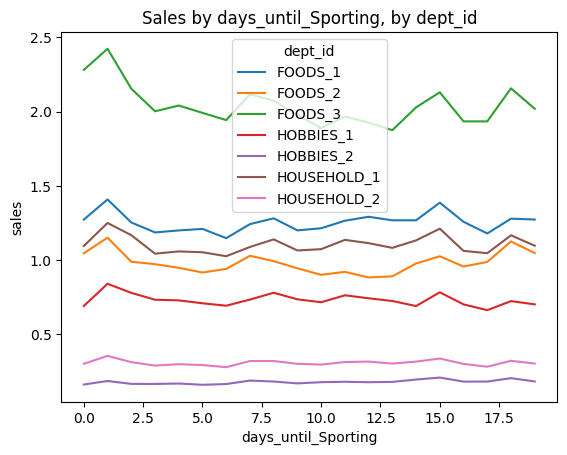

In [36]:
for col in ["days_until_Religious", "days_until_National", "days_until_Cultural", "days_until_Sporting"]:
    days_until_groupby = data.groupby(["dept_id", col])["sales"].mean().reset_index()
    sns.lineplot(days_until_groupby[days_until_groupby[col]<20],
             x=col, y="sales", hue="dept_id")
    plt.title(f"Sales by {col}, by dept_id")
    plt.show()

**Bottom Line**
- Religious event - not much effect. On the weekend before the event there is a slight increse in sales
- National event - On the actual day of the event the is a significant drop in sales
- On the say or two before the cultural or sport event we a significant increase in sales

# Price Effects

In [41]:
samples_data['ratio_to_4wk_mean'].min()

np.float16(0.002012)

In [42]:
samples_data['ratio_to_4wk_mean'].max()

np.float16(15.72)

In [45]:
samples_data["ratio_to_4wk_mean"] = samples_data["ratio_to_4wk_mean"].astype("float64")

In [58]:
# Segment (cut) the ratio_to_4wk_mean column
bins = [0.0, 0.5, 0.9, 0.97, 0.98, 0.99,1.0, 1.03, 1.1, 1.5, 2.0, 20.0]
samples_data["ratio_to_4wk_mean_cut"] = pd.cut(samples_data["ratio_to_4wk_mean"], bins=bins)

In [59]:
samples_data["ratio_to_4wk_mean_cut"].value_counts().sort_index()

,count
ratio_to_4wk_mean_cut,
"(0.0, 0.5]",905
"(0.5, 0.9]",8778
"(0.9, 0.97]",14503
"(0.97, 0.98]",3988
"(0.98, 0.99]",4074
"(0.99, 1.0]",2873566
"(1.0, 1.03]",21123
"(1.03, 1.1]",24233
"(1.1, 1.5]",13496


In [60]:
sales_by_4wk_cut = samples_data.groupby(["ratio_to_4wk_mean_cut"])["sales"].mean()

<ipython-input-60-46862a8008c0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_4wk_cut = samples_data.groupby(["ratio_to_4wk_mean_cut"])["sales"].mean()


In [61]:
sales_by_4wk_cut

,sales
ratio_to_4wk_mean_cut,
"(0.0, 0.5]",1.474033
"(0.5, 0.9]",2.078036
"(0.9, 0.97]",1.838585
"(0.97, 0.98]",1.875125
"(0.98, 0.99]",1.856406
"(0.99, 1.0]",1.102217
"(1.0, 1.03]",1.897647
"(1.03, 1.1]",2.061445
"(1.1, 1.5]",2.199170


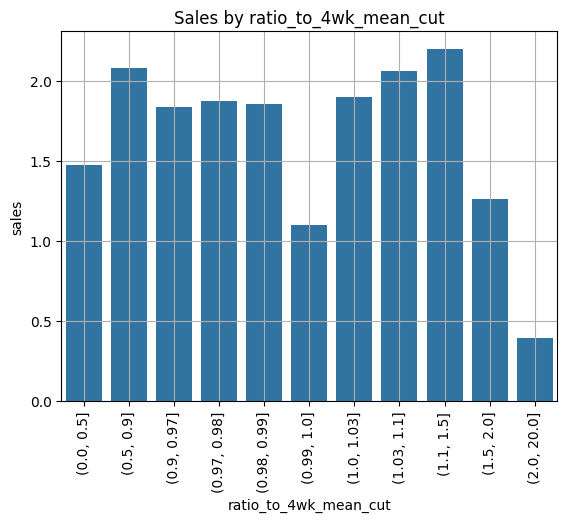

In [68]:
sns.barplot(data=sales_by_4wk_cut.to_frame(), x="ratio_to_4wk_mean_cut", y="sales")
plt.grid()
plt.xticks(rotation=90)
plt.title("Sales by ratio_to_4wk_mean_cut")
plt.show()

In [71]:
samples_data["week_to_week_ratio"] = samples_data["week_to_week_ratio"].astype("float64")
samples_data["week_to_week_ratio_cut"] = pd.cut(samples_data["week_to_week_ratio"], bins=bins)
samples_data["week_to_week_ratio_cut"].value_counts().sort_index()

,count
week_to_week_ratio_cut,
"(0.0, 0.5]",757
"(0.5, 0.9]",4971
"(0.9, 0.97]",3861
"(0.97, 0.98]",577
"(0.98, 0.99]",537
"(0.99, 1.0]",2938754
"(1.0, 1.03]",2831
"(1.03, 1.1]",5559
"(1.1, 1.5]",5720


In [72]:
sales_by_week_ratio_cut = samples_data.groupby(["week_to_week_ratio_cut"])["sales"].mean()

<ipython-input-72-820ae4d3fd4b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_week_ratio_cut = samples_data.groupby(["week_to_week_ratio_cut"])["sales"].mean()


In [73]:
sales_by_week_ratio_cut

,sales
week_to_week_ratio_cut,
"(0.0, 0.5]",1.467635
"(0.5, 0.9]",1.649165
"(0.9, 0.97]",1.455581
"(0.97, 0.98]",2.155979
"(0.98, 0.99]",1.175047
"(0.99, 1.0]",1.123753
"(1.0, 1.03]",1.730837
"(1.03, 1.1]",1.918690
"(1.1, 1.5]",2.067657


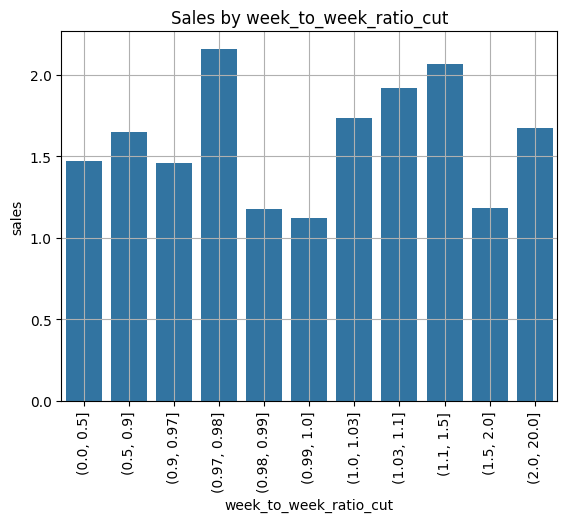

In [74]:
sns.barplot(data=sales_by_week_ratio_cut.to_frame(), x="week_to_week_ratio_cut", y="sales")
plt.grid()
plt.xticks(rotation=90)
plt.title("Sales by week_to_week_ratio_cut")
plt.show()